# Install kaggle-environments

In [ ]:
# 1. Enable Internet in the Kernel (Settings side pane)

# 2. Curl cache may need purged if v0.1.6 cannot be found (uncomment if needed). 
!curl -X PURGE https://pypi.org/simple/kaggle-environments

# ConnectX environment was defined in v0.1.6
!pip install 'kaggle-environments>=0.1.6'

# Create ConnectX Environment

In [ ]:
from kaggle_environments import evaluate, make, utils
import numpy as np
import time

env = make("connectx", debug=True)
env.render()

# Mi Codigo

In [ ]:
from abc import abstractmethod


class IGame:

    @abstractmethod
    def is_game_over(board, inarow):
        pass

    @abstractmethod
    def change_turn(player):
        pass

    @abstractmethod
    def get_open_cols(board):
        pass

    @abstractmethod
    def make_move(board, col, player):
        pass

    @abstractmethod
    def get_turn(board):
        pass

    @abstractmethod
    def print_board(board):
        pass

In [ ]:
import numpy as np


class Connectx(IGame):
    def __init__(self, inarow, rows, cols):
        self.cols = cols
        self.rows = rows
        self.inarow = inarow
        

    def change_turn(self, player): 
        if player == '1':
            return '2'
        else:
            return '1'


    def get_open_cols(self, board):
        # board is serialized
        # this order is better because the ia will start the search from the most centered columns
        return [i for i in [3,4,2,5,1,6,0] if board[i] == '0']

    def make_move(self, board, col, player):

        entire_col = [board[i*self.cols + col] for i in range(self.rows)]
        for i, cell in enumerate(reversed(entire_col)):
            if cell == '0':
                board = board[:(self.rows-i-1)*self.cols + col] + player + board[(self.rows-i-1)*self.cols+col+1:]
                break
        return board

    def get_turn(self, board):
        # assuming that '1' always starts playing
        ones = board.count('1')
        twos = board.count('2')
        return '1' if ones == twos else '2'

    def is_game_over(self, board, inarow):
        '''
        return the winner or '0' if there is no winner
        '''
        board2d = self.deserialize_board(board)
        
        # rows
        for i in range(self.rows):
            previous = ''
            count = 1
            for j in range(self.cols):
                current = board[i*self.cols + j]
                if previous != '0' and previous == current:
                    count += 1
                else:
                    count = 1
                if count == inarow:
                    return current
                previous = current
        
        # columns
        for i in range(self.cols):
            previous = ''
            count = 1
            for j in range(self.rows):
                current = board[j*self.cols + i]
                if previous != '0' and previous == current:
                    count += 1
                else:
                    count = 1
                if count == inarow:
                    return current
                previous = current
        
        # positive diagonal
        for row in range(self.rows-(inarow-1)):
            for col in range(self.cols-(inarow-1)):
                window = list(board2d[range(row, row+inarow), range(col, col+inarow)])
                
                if window.count('1') == inarow:
                    return '1'
                elif window.count('2') == inarow:
                    return '2'

        # negative diagonal
        for row in range(inarow-1, self.rows):
            for col in range(self.cols-(inarow-1)):
                window = list(board2d[range(row, row-inarow, -1), range(col, col+inarow)])
                if window.count('1') == inarow:
                    return '1'
                elif window.count('2') == inarow:
                    return '2'
        return '0' if board.count('0') != 0 else 'draw'

    def print_board(self, board):
        for i in range(self.rows):
            print('|', end='')
            for j in range(self.cols):
                print(board[i*self.cols + j], end='|')
            print()
        print(board)

    def serialize_board(self, board):
        return ''.join([str(cell) for row in board for cell in row])

    def deserialize_board(self, board: str):
        arr = np.array(list(board))
        arr = arr.reshape((self.rows, self.cols))
        return arr

In [ ]:
class MCTS:
     # hiperparameter to manage expliotation vs exploration

    def __init__(self, game: IGame):
        self.explored = set() # fen: value // eliminar??
        self.nodes_parameters = {} # fen: (N, V) N--> times visited, V-->value
        # self.UCT = {} # fen: UPC (upper confidence tree)
        self.C = 1.4 # aprox sqrt(2)
        self.game = game

    def get_value(self, result: str, player):
        if result == '1':
            return 1 if player == '1' else -1

        elif result == '2':
            return -1 if player == '1' else 1 
        else:
            return 0

    def search(self, s):
        result = self.game.is_game_over(s, self.game.inarow)
        if result != '0':
            v = self.get_value(result, self.game.get_turn(s)) 
            if s not in self.nodes_parameters:
                self.nodes_parameters[s] = np.array((1, v))
            else:
                self.nodes_parameters[s][0] += 1
            return -v, 1

        childs = self.game.get_open_cols(s)

        if s in self.explored:
        # choose which node is going to be expanded
            best_uct = float('-inf')
            best_child = None
            turn = self.game.get_turn(s)
            # best_w = 0
            n_p = self.nodes_parameters[s][0] # parent's n
            for a in childs:
                s_child = self.game.make_move(s, a, turn)
                n, w = self.nodes_parameters[s_child]
                child_uct = self.get_UCT(n, w, n_p)
                if child_uct > best_uct:
                    best_uct = child_uct
                    best_child = a
            s_aux = self.game.make_move(s, best_child, self.game.get_turn(s))
            sum_v, sum_n = self.search(s_aux)
            # propagate the results
            self.nodes_parameters[s_aux][0] += sum_n
            self.nodes_parameters[s_aux][1] += sum_v

        
        else:
            self.explored.add(s)
            sum_v = 0
            sum_n = 0
            turn = self.game.get_turn(s)
            for a in childs:
                s_child = self.game.make_move(s, a, turn)
                if s_child not in self.nodes_parameters:
                    v = self.simulate(s_child, turn, turn)
                    self.nodes_parameters[s_child] = np.array((1, v))
                    sum_v += v
                    sum_n += 1
                
            self.nodes_parameters[s][0] += sum_n
            self.nodes_parameters[s][1] += sum_v

        return -sum_v, sum_n

    def simulate(self, s, color_playing, turn):
        result = self.game.is_game_over(s, 4)
        while result == '0': #TODO usar variable inarow
            move = np.random.choice(self.game.get_open_cols(s))
            s = self.game.make_move(s, move, turn)
            result = self.game.is_game_over(s, 4)
            turn = self.game.change_turn(turn)
        return self.get_value(result, color_playing)


    def get_UCT(self, n, w, n_p):
        # return w/n + self.C * np.sqrt(n_p) / (1 + n)
        return w/n + self.C * np.sqrt(np.log(n_p) / n)

    def iterate(self, s, n_iters=None, time_limit=None):
        self.nodes_parameters[s] = np.array((1, 0))
        if time_limit is not None:
            end_time = time.time() + time_limit
            while time.time() < end_time:
                v, n = self.search(s)
                self.nodes_parameters[s][0] += n
                self.nodes_parameters[s][1] += v
        else:
            for _ in range(n_iters):
                v, n = self.search(s)
                self.nodes_parameters[s][0] += n
                self.nodes_parameters[s][1] += v
                # if i % 10 == 0:
                #     print(f'Iteration {i+1} [{"=" * (i//5)}>{" " * ((n_iters-i-1)//5)}]')

    def best_move(self, board, turn, n_iters=None, time_limit=None):
        self.iterate(board, n_iters=n_iters, time_limit=time_limit)
        max_n = 0
        best_move = 3 # por ejemplo 3
        for a in self.game.get_open_cols(board):
            c_aux = self.game.make_move(board, a, turn)
            if self.game.is_game_over(c_aux, self.game.inarow) != '0':
                return a
            current_n = self.nodes_parameters[c_aux][0]
            if current_n > max_n:
                max_n = current_n
                best_move = a
            # print(f'N: {self.nodes_parameters[c_aux][0]} , V: {self.nodes_parameters[c_aux][1]}')
            # self.game.print_board(c_aux)
        return best_move



# Neural Network

In [3]:
from tensorflow.keras.layers import Input, Conv2D, Dense, BatchNormalization, ReLU, Add, Flatten
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

class NeuralNetwok():
    

    def __init__(self, rows, cols, l_rate):
        self.rows = rows
        self.cols = cols
        self.l_rate = l_rate
        self.N_BLOCKS = 2
        self.KERNEL_SIZE = (3, 3) # the stride will be 1 (the default used by keras)
        self.FILTERS = 128
        self.model = self.create_model(rows, cols, self.N_BLOCKS)
        
    
    def create_model(self, rows, cols, n_blocks):
        # input of the neural network
        input_layer = Input(shape=(rows, cols, 1))
        
        # body (residual blocks)
        x = self.add_convolutional_layer(input_layer, self.FILTERS, self.KERNEL_SIZE)
        for _ in range(n_blocks):
            x = self.add_residual_block(x)
            
        # add policy head
        policy_head_output = self.add_policy_head(x)
        
        # add value head
        value_head_output = self.add_value_head(x)
        
        model = Model(inputs=input_layer, outputs=[policy_head_output, value_head_output])
        model.compile(
            optimizer = Adam(self.l_rate),
            loss = ['categorical_crossentropy','mean_squared_error']
        )
        return model
        
    def add_residual_block(self, x):
        # first convolutional layer
        y = self.add_convolutional_layer(x, self.FILTERS, self.KERNEL_SIZE)
        
        # second convolutional layer
        y = Conv2D(self.FILTERS, self.KERNEL_SIZE, padding='same')(y)
        y = BatchNormalization()(y)
        y = Add()([x, y])
        y = ReLU()(y)
        return y
    
    def add_convolutional_layer(self, x, filters, kernel_size):
        y = Conv2D(filters, kernel_size, padding='same')(x) # padding has to be 'same' in order to keep the dimensions right
        y = BatchNormalization()(y)
        y = ReLU()(y)
        return y
    
    def add_policy_head(self, x):
        y = self.add_convolutional_layer(x, 2, (1, 1))
        y = Flatten()(y)
        y = Dense(self.cols, activation='softmax')(y) # TODO: podria llegar a hacerse de tamaño rows*cols, ni idea
        # move logit probabilities
        return y
    
    def add_value_head(self, x):
        y = self.add_convolutional_layer(x, 1, (1, 1))
        y = Flatten()(y)
        y = Dense(128)(y)
        y = ReLU()(y)
        y = Dense(1, activation='tanh')(y)
        return y
    
    def predict(self, x):
        return self.model.predict(x)
    
    def train(self, x, y):
        return
        history = self.model.train()

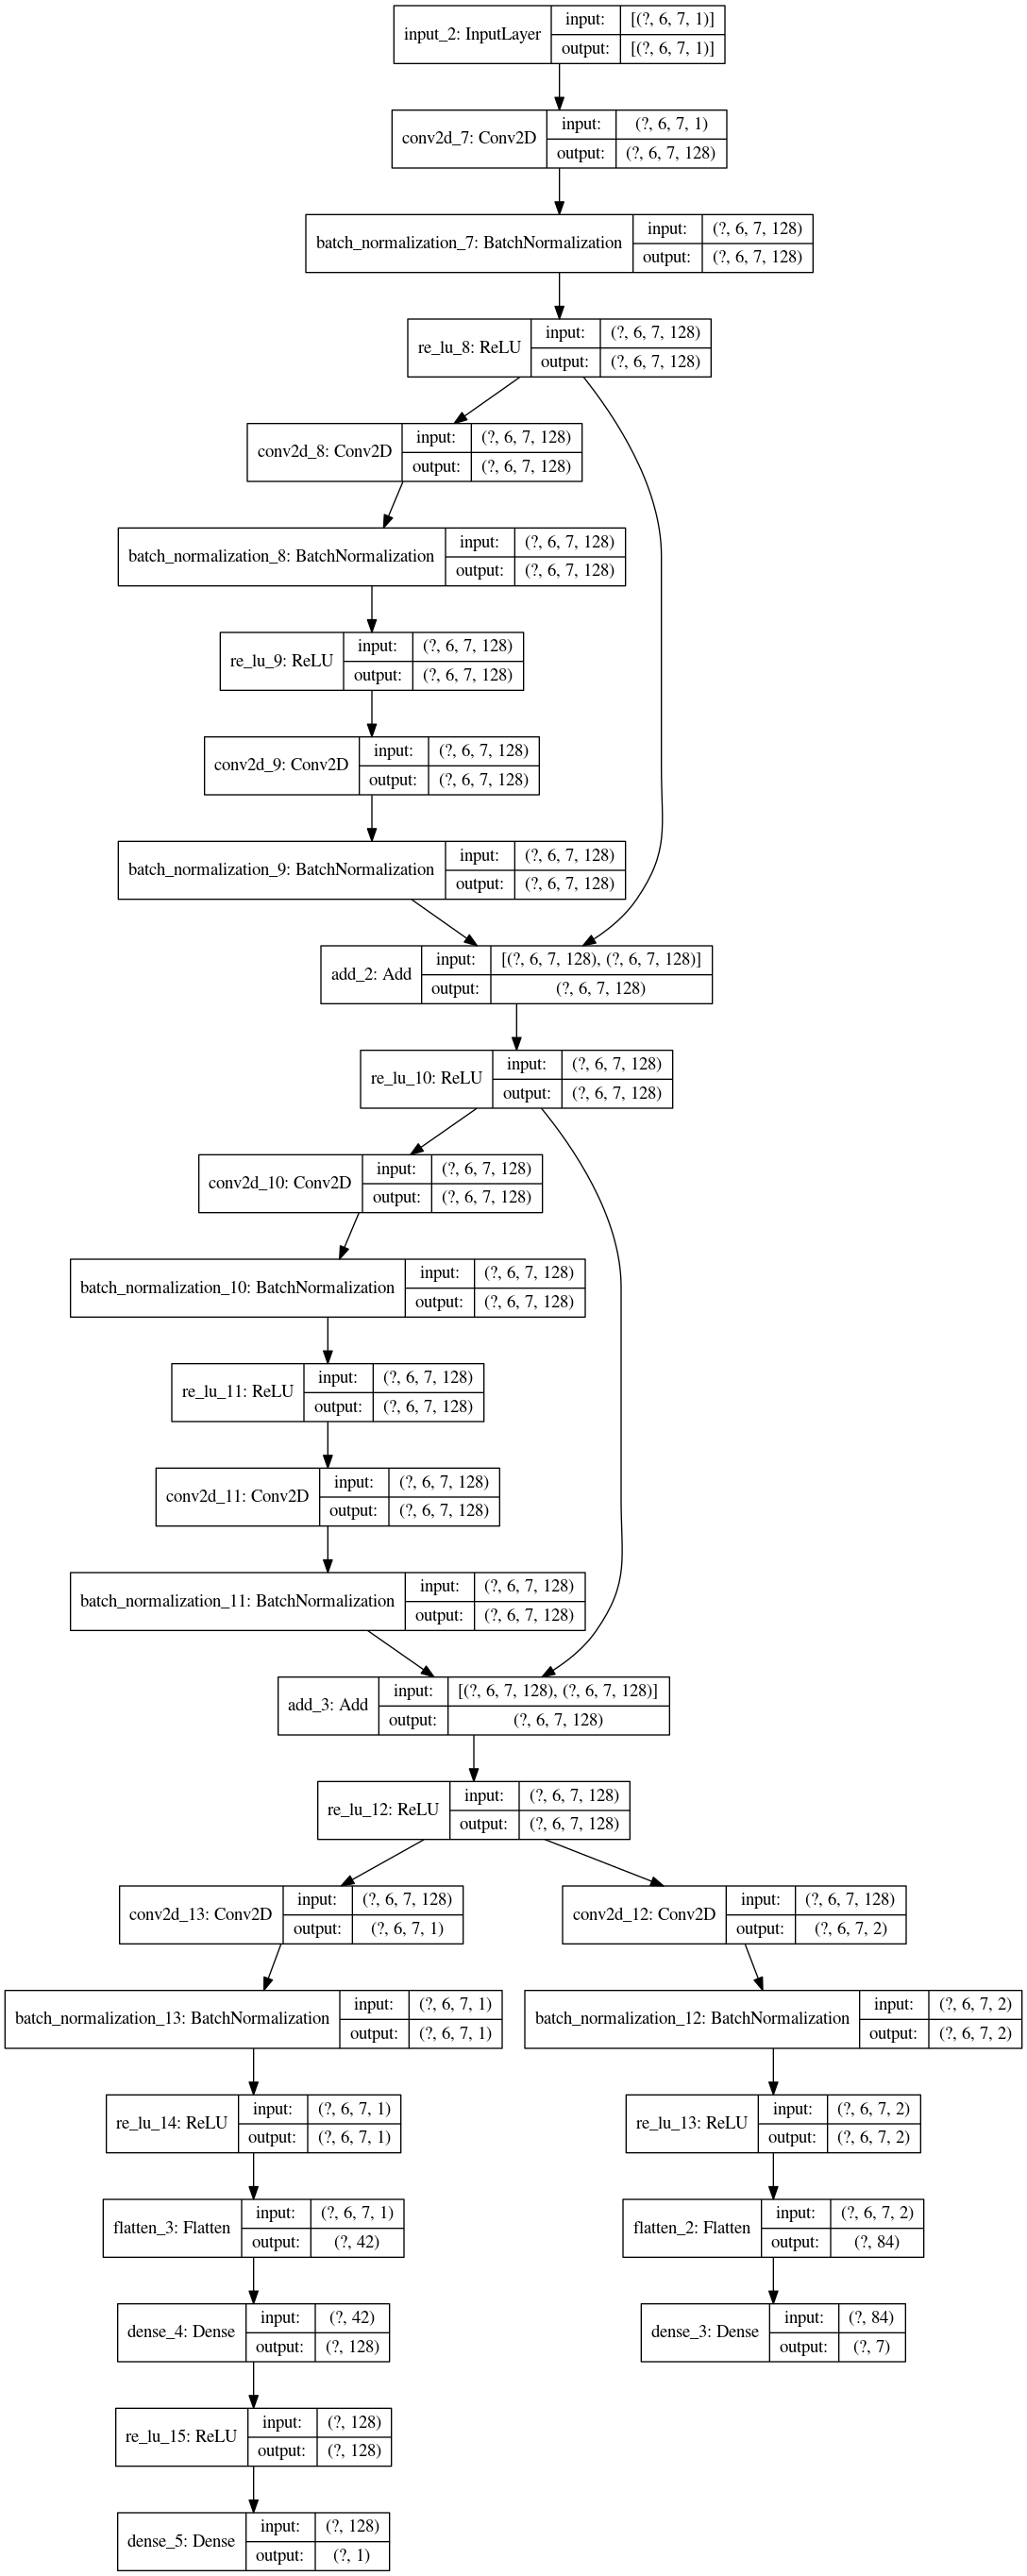

In [5]:
nn = NeuralNetwok(6, 7, 0.01)
plot_model(nn.model, show_shapes=True)

# Create an Agent

To create the submission, an agent function should be fully encapsulated (no external dependencies).  

When your agent is being evaluated against others, it will not have access to the Kaggle docker image.  Only the following can be imported: Python Standard Library Modules, gym, numpy, scipy, pytorch (1.3.1, cpu only), and more may be added later.



In [ ]:
import functools
import keras
# This agent random chooses a non-empty column.

def my_agent(observation, configuration):
    board = functools.reduce(lambda x, y: str(x) + str(y), observation.board)
    game = Connectx(configuration.inarow, configuration.rows, configuration.columns)
    mcts = MCTS(game)
    turn = str(observation.mark)
    
#     print(turn, configuration.rows, configuration.columns)
#     print(board)
    game.print_board(board)
    move = mcts.best_move(board, turn, n_iters=150)
    for a in mcts.game.get_open_cols(board):
        c_aux = mcts.game.make_move(board, a, turn)
        print(f'N: {mcts.nodes_parameters[c_aux][0]} , V: {mcts.nodes_parameters[c_aux][1]}')
#     print(move)
    return move

# Test your Agent

In [ ]:
env.reset()
# Play as the first agent against default "random" agent.
env.run(["negamax", my_agent])
env.render(mode="ipython", width=500, height=450)

# Debug/Train your Agent

In [ ]:
# Play as first position against random agent.
trainer = env.train([None, "random"])

observation = trainer.reset()

while not env.done:
    my_action = my_agent(observation, env.configuration)
    print("My Action", my_action)
    observation, reward, done, info = trainer.step(my_action)
    # env.render(mode="ipython", width=100, height=90, header=False, controls=False)
env.render()

# Evaluate your Agent

In [ ]:
def mean_reward(rewards):
    return sum(r[0] for r in rewards) / float(len(rewards))

# Run multiple episodes to estimate its performance.
print("My Agent vs Random Agent:", mean_reward(evaluate("connectx", [my_agent, "random"], num_episodes=10)))
print("My Agent vs Negamax Agent:", mean_reward(evaluate("connectx", [my_agent, "negamax"], num_episodes=10)))

# Play your Agent
Click on any column to place a checker there ("manually select action").

In [ ]:
# "None" represents which agent you'll manually play as (first or second player).
env.play([my_agent, None], width=500, height=450)

# Write Submission File



In [ ]:
import inspect
import os

def write_agent_to_file(function, file):
    with open(file, "a" if os.path.exists(file) else "w") as f:
        f.write(inspect.getsource(function))
        print(function, "written to", file)

write_agent_to_file(my_agent, "submission.py")

# Validate Submission
Play your submission against itself.  This is the first episode the competition will run to weed out erroneous agents.

Why validate? This roughly verifies that your submission is fully encapsulated and can be run remotely.

In [ ]:
# Note: Stdout replacement is a temporary workaround.
import sys
out = sys.stdout
submission = utils.read_file("/kaggle/working/submission.py")
agent = utils.get_last_callable(submission)
sys.stdout = out

env = make("connectx", debug=True)
env.run([agent, agent])
print("Success!" if env.state[0].status == env.state[1].status == "DONE" else "Failed...")

# Submit to Competition

1. Commit this kernel.
2. View the commited version.
3. Go to "Data" section and find submission.py file.
4. Click "Submit to Competition"
5. Go to [My Submissions](https://kaggle.com/c/connectx/submissions) to view your score and episodes being played.